# WaveMap spike profiles test X

Purpose: test different feature engineering for spike waveforms that maximizes good cluster separations of units based on six channel spike profile 

Method: 
- curation: single units (kslabel="good"), in cortex
- ordering from largest to smallest first positive peak amplitude (or trough or second positive peak) of the template, depending in which is the largest
- unit spikes are aligned by first extracting -6:+6 ms before and after the spike timestamp then centering unit templates on their trough (maximal negative peak), teducing the template period to -3:+3 ms before applying wavemap
- template is the mean over spikes of each unit, defined over a 6 ms period (period of spike return to baseline, using larger period detected the same number of clusters)
Pros:
- This is the method that best matched Paulk et al. with in vivo Marques, so we chose it.
- selected sites are in the same local neighborhood

* UMAP reduces to 2 dimensions by default.

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import sklearn.preprocessing
import os
import random
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
import pandas as pd
from matplotlib import cm
from matplotlib import pyplot as plt
from collections import Counter

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("silico_neuropixels", "2023_10_18").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["sorted"]["for_wavemap"]["study"]
SORTED_sili = data_conf_sili["sorting"]["sorters"]["kilosort3"]["output"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
LINEWIDTH = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
tight_layout_cfg = {"pad": 0.1}

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back

2024-02-08 17:20:16,415 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-08 17:20:16,446 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Build spike instances for wavemap with the units with the 5 typical profiles

In [2]:
# takes 0.4 secs
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)

# load waveforms
WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# number of waveform samples
nsamples = WaveformExtractor.nsamples

In [3]:
# get sites in cortex (units in cortex will be curated)
# SITES_IN_CTX = np.where(Recording.get_property("layers") != ["Outside"])[0]
SITES_IN_CTX = np.arange(0, 384, 1)

In [4]:
def get_unit_largest_templates_parallelized(dummy, cell_id: int):

    N_SPIKES = 6
    N_SITES = len(SITES_IN_CTX)
    MSAMP_BASELINE = 20

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get -3 and +3ms period to discard
    # collision from other spike or noise
    # wfs = wfs[240 - 120 : 240 + 120, :, :]

    # get this unit's templates per site
    site_templates = []
    peak1_amps = []
    trough_amps = []
    peak2_amps = []

    # get template features per sites
    for ix, site in enumerate(SITES_IN_CTX):

        # calculate template
        template = np.median(wfs[:, :, site].T, axis=1)

        # subtract baseline
        template -= np.median(template[:MSAMP_BASELINE])

        # find peak 1 trough, and peak 2 amps
        # - if trough is at time 0, too much noise
        # set site data to 0 -> will not be picked
        # up for max trough, or peak
        ix_trough = np.argmin(template)
        if ix_trough == 0:
            peak1_amps.append(0)
            trough_amps.append(0)
            peak2_amps.append(0)
        else:
            peak1_amps.append(template[np.argmax(template[:ix_trough])])
            trough_amps.append(template[ix_trough])
            peak2_amps.append(template[np.argmax(template[ix_trough:])])

        # record templates
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get amplitudes from peak1 (row 1), trough (row 2)or peak2 (row3),
    # depending on which is largest across sites
    peaks_and_trough = np.vstack(
        [np.array(peak1_amps), np.array(trough_amps), np.array(peak2_amps)]
    )
    peak1_trough_or_peak2 = np.argmax(np.nanmax(np.abs(peaks_and_trough), axis=1))

    # if peak, reorder sites based on peak, else on trough
    descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])[::-1]

    # case trough
    if peak1_trough_or_peak2 == 1:
        descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])

    # order associated sites
    ordered_sites = np.arange(0, N_SITES, 1)[descend_sort_ix]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return {"templates": unit_i_spike, "sites": ordered_sites}


def plot_site_coords(selected_unit: int, ordered_sites, Recording):

    # show 6 largest sites for selected unit
    largest_sites = ordered_sites[selected_unit][:6]
    print("ordered sites:", largest_sites)

    Probe = Recording.get_probe()

    # plot file contact with ids
    # fig, ax = plt.subplots(1, 1, figsize=(2, 10), mode="projection_3D")
    ax = plt.figure(figsize=(20, 40)).add_subplot(projection="3d")
    ax.view_init(0, -40, 0)
    ax.plot(
        Probe.contact_positions[:, 0],
        Probe.contact_positions[:, 1],
        Probe.contact_positions[:, 2],
        "o",
        markerfacecolor="w",
        color="k",
        markersize=5,
    )

    coord2 = Probe.contact_positions[np.array(largest_sites), :]

    # plot file contact with ids
    ax.plot(
        coord2[:, 0],
        coord2[:, 1],
        coord2[:, 2],
        "o",
        markerfacecolor="r",
        color="k",
        markersize=5,
    )
    for ix in range(len(coord2)):
        if ix % 1 == 0:
            ax.text(
                coord2[ix, 0],
                coord2[ix, 1] - 100,
                coord2[ix, 2],
                "%s" % (str(largest_sites[ix])),
                size=6,
                zorder=100,
                color="r",
            )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)

### Unit curation

In [5]:
# curate single units (postprocessing)
Sorting = si.load_extractor(SORTED_sili)

# get single units
is_single_unit = Sorting.get_property("KSLabel") == "good"

# get units in cortex
is_in_ctx = Sorting.get_property("layer") != "Outside"

# curate units
single_units = WaveformExtractor.unit_ids[is_single_unit & is_in_ctx]

# chosen single channel single units examples
selected_units = [142, 150, 270, 196, 200]

### Create WaveMap waveform dataset

In [6]:
# takes 0.9 secs for 4 units

# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, 10, 1),  # dummy not used
        selected_units,
    )
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
sites = []
for ix in range(len(selected_units)):
    site_templates_all.append(site_templates[ix]["templates"].tolist())
    sites.append(site_templates[ix]["sites"].tolist())
templates_for_wavemap = np.array(site_templates_all)

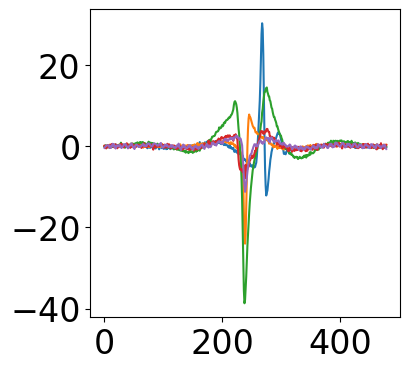

In [7]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(templates_for_wavemap[0, :nsamples])
ax.plot(templates_for_wavemap[1, :nsamples])
ax.plot(templates_for_wavemap[2, :nsamples])
ax.plot(templates_for_wavemap[3, :nsamples])
ax.plot(templates_for_wavemap[4, :nsamples])

### Check site locations

The sites with largest amplitudes always form a neighborhood.

ordered sites: [38, 133, 37, 134, 230, 229]


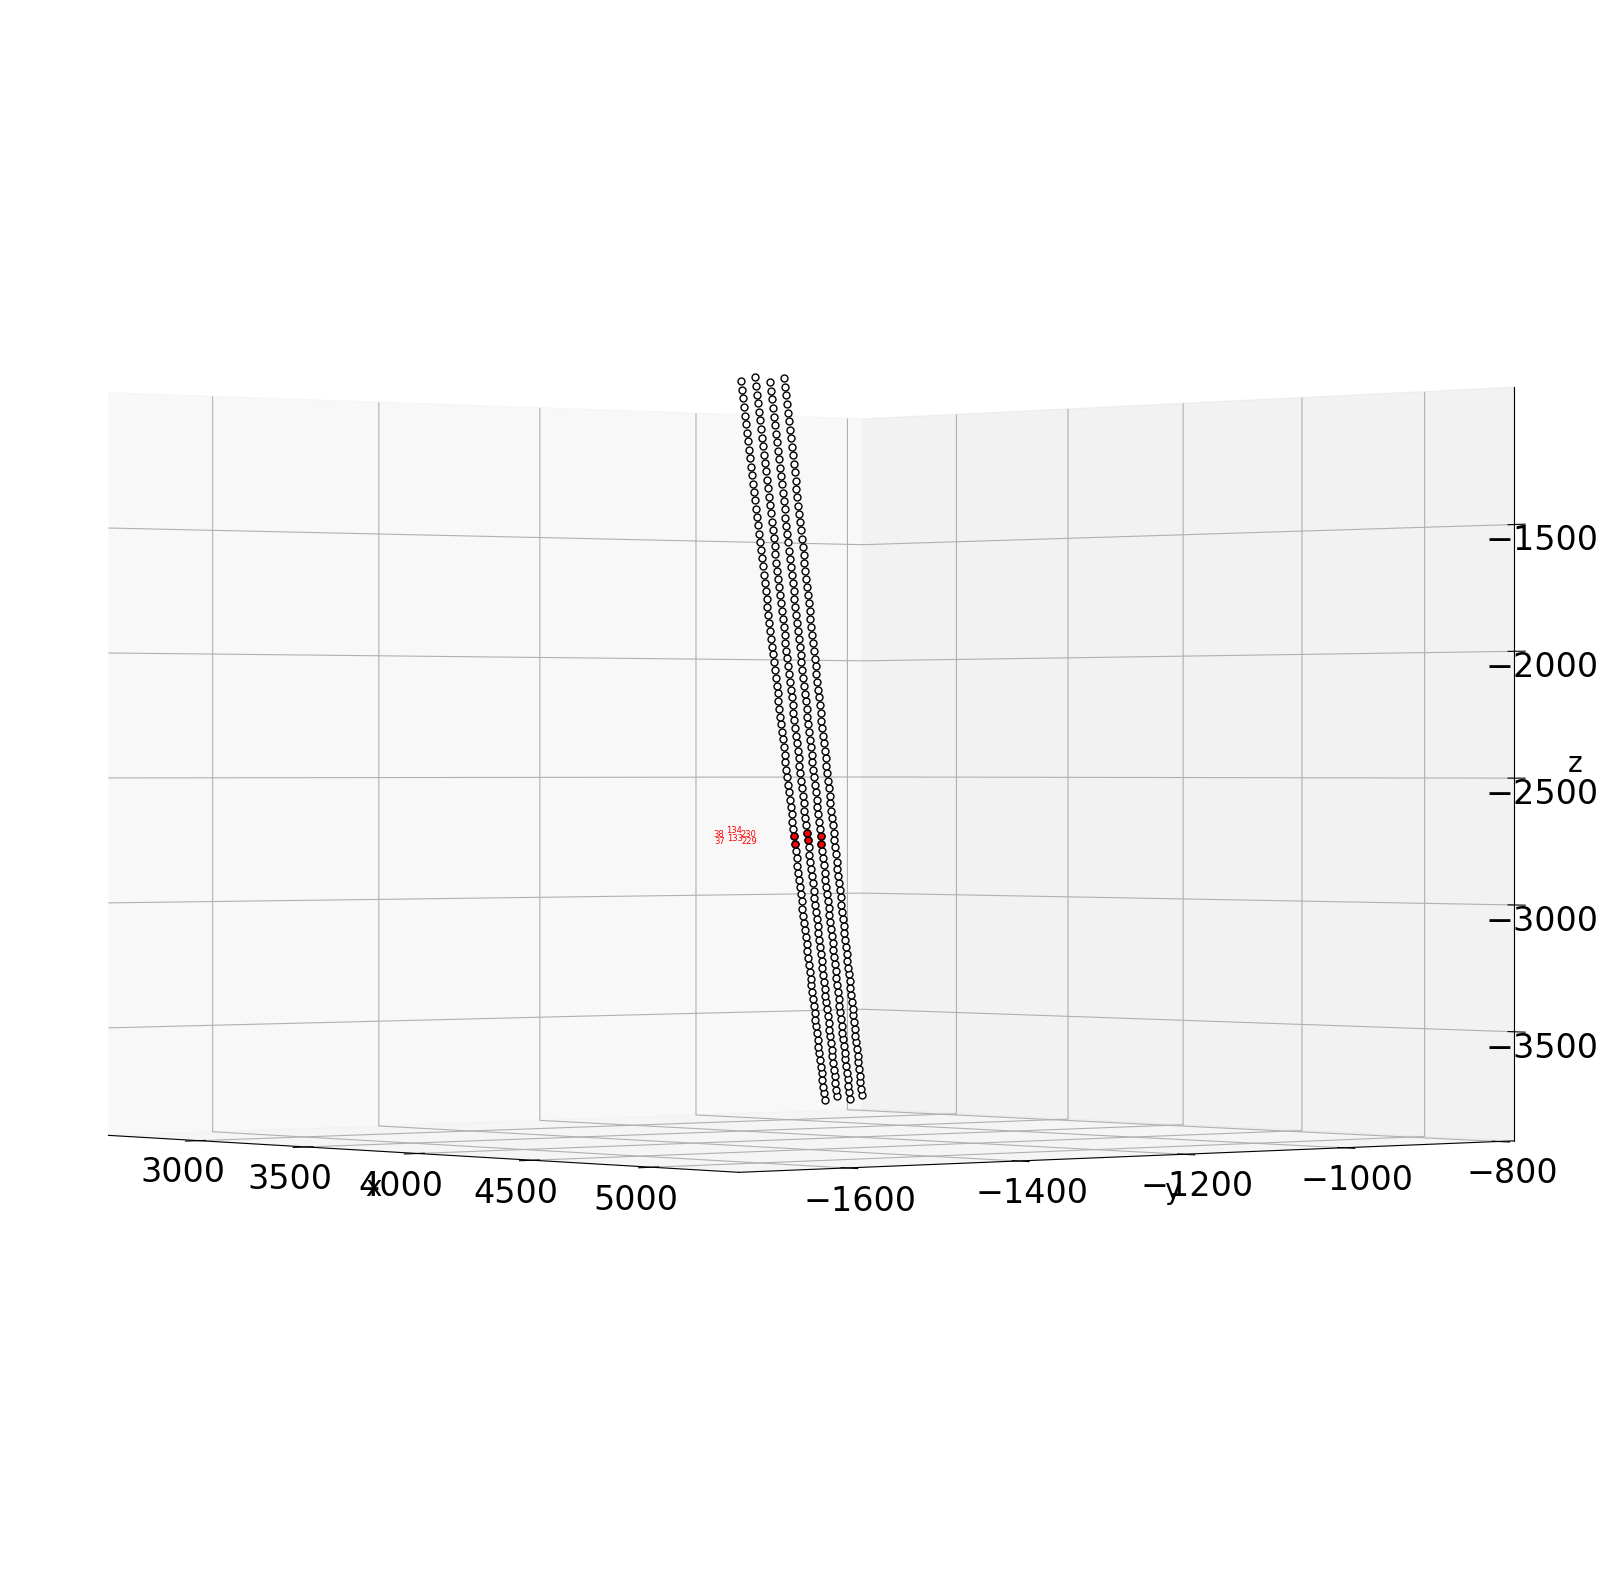

In [8]:
SELECTED_UNIT = 4

plot_site_coords(SELECTED_UNIT, sites, Recording)

### Create WaveMap waveform dataset

In [9]:
# takes 3 min for the 227 single units (KSLabel)
# takes 8 mins for all (1310) units
# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor() as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, len(single_units), 1),  # dummy, not used
        single_units,
    )

# collect
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
sites = []
for ix in range(len(single_units)):
    site_templates_all.append(site_templates[ix]["templates"].tolist())
    sites.append(site_templates[ix]["sites"].tolist())
templates_for_wavemap = np.array(site_templates_all)

print(templates_for_wavemap.shape)

(228, 2880)


### Cluster with six-site WaveMap

In [40]:
ALIGNED_MAX_AFTER = 120  # 2.25 ms after
ALIGNED_MAX_BEFORE = 120  # 2.25 ms msec before

n_sites_for_umap = int(templates_for_wavemap.shape[1] / nsamples)

# isolate each unit's largest template
largest_templates = templates_for_wavemap[:, :nsamples]

aligned_temps = []

for ix in range(len(single_units)):

    # find trough
    ix_trough = np.argmin(largest_templates[ix, :])

    # align the templates for each site
    # to the location of the first positive peak of
    # the largest template
    templates_unit_i = []
    for jx in range(n_sites_for_umap):

        # align to the first positive peak
        try:
            templates_unit_i.append(
                templates_for_wavemap[
                    ix,
                    jx * nsamples
                    + ix_trough
                    - ALIGNED_MAX_BEFORE : jx * nsamples
                    + ix_trough
                    + ALIGNED_MAX_AFTER,
                ]
            )
        except:
            print("reduce the length of the preceding and following periods")

    # re-concatenate into a single row vector
    templates_unit_i = np.array(templates_unit_i).flatten()
    aligned_temps.append(templates_unit_i)

aligned_temps = np.array(aligned_temps)

# sanity check
assert all(np.sum(aligned_temps, axis=1)), "some voltages are nan"

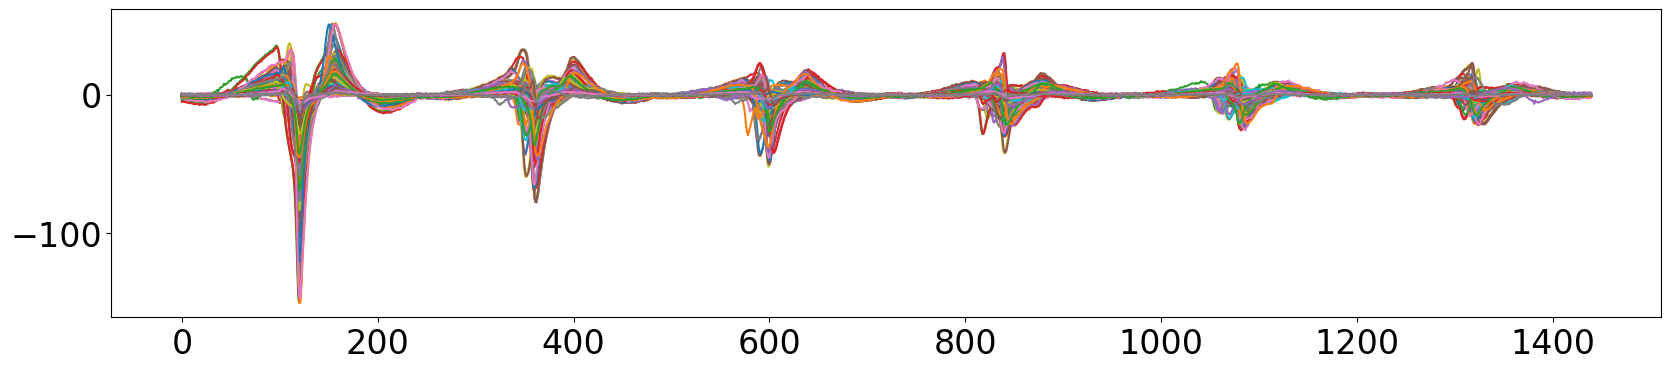

In [41]:
# plot all single units
plt.subplots(1, 1, figsize=(20, 4))
plt.plot(aligned_temps.T)

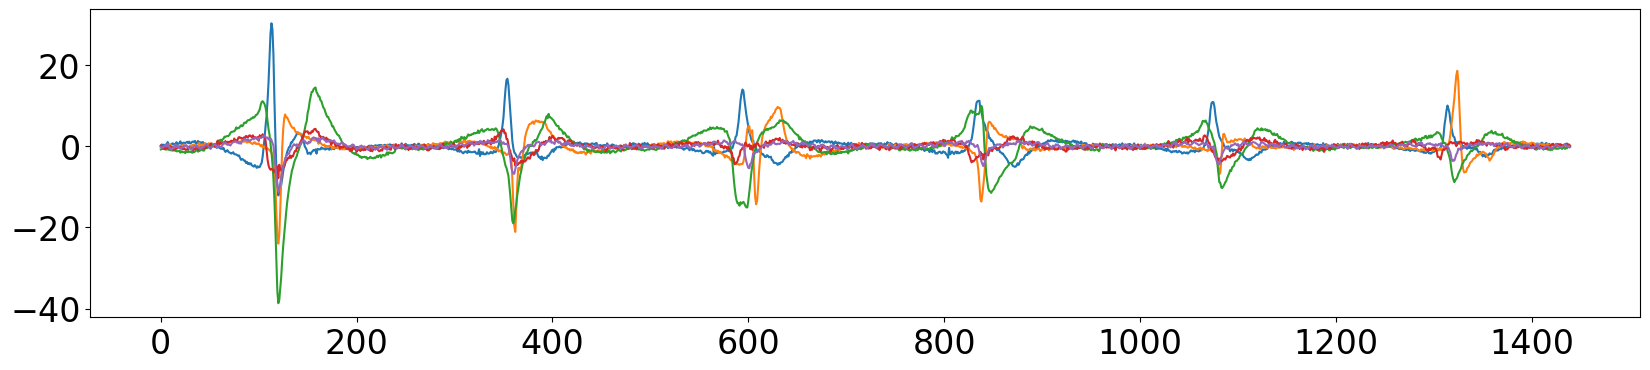

In [42]:
# plot trough-aligned selected single-channel single units
plt.subplots(1, 1, figsize=(20, 4))
for ix in range(len(selected_units)):
    plt.plot(aligned_temps[np.where(single_units == selected_units[ix])[0][0], :].T)

In [43]:
# takes 13 secs
SPIKE_PERIOD = int(
    aligned_temps.shape[1] / n_sites_for_umap
)  # in timepoints (6 ms at 40KHz)
RAND_STATE = 42  # 42

# normalize waveform amplitudes between 0 and 1.
normWFs = sklearn.preprocessing.normalize(aligned_temps, norm="max")

# reduce waveform dimensionality with UMAP
# umap reduces to two dimensions by default
np.random.seed(RAND_STATE)
os.environ["PYTHONHASHSEED"] = str(RAND_STATE)
random.seed(RAND_STATE)
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

# clustering with Louvain
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = community_louvain.best_partition(G)
clustering_solution = list(clustering.values())

# create 2D embedding
embedding = reducer.fit_transform(normWFs)

# get cluster profiles
umap_df = pd.DataFrame(embedding, columns=("x", "y"))
umap_df["waveform"] = list(normWFs)
umap_df["cluster_id"] = clustering_solution

profiles = np.unique(umap_df["cluster_id"])

Plot the WaveMAP embedding

profile (count): 7
profiles: [3, 5, 4, 1, 0, 2]


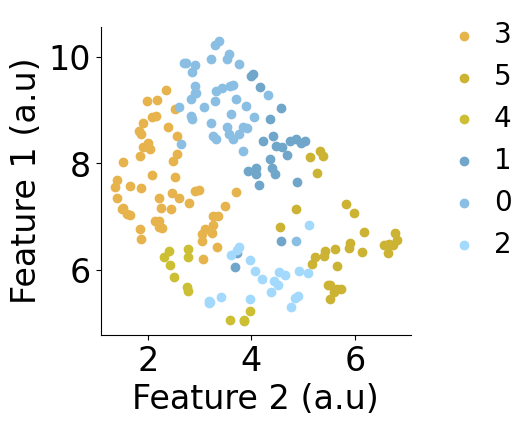

In [72]:
# set profile colors
colors = np.array(
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        # [1, 0, 0],  # red
        # [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        # [254 / 255, 235 / 255, 226 / 255],  # purple variation
        # [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

# plot embedding
f, ax = plt.subplots(1, figsize=FIG_SIZE)
for ix, profile_i in enumerate(profiles):
    ax.scatter(
        umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
        umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
        marker="o",
        color=colors[ix],
        label=profile_i,
    )

# legend
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Feature 1 (a.u)")
ax.set_xlabel("Feature 2 (a.u)")
# ax.set_xticks([0, 3, 6])
# ax.set_xticklabels([0, 3, 6])
# ax.set_yticks([-2, 0, 2])
# ax.set_yticklabels([-2, 0, 2])
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **legend_cfg)

# print cluster profiles
print("profile (count):", len(np.unique(umap_df["cluster_id"])))
print("profiles:", profiles)

# save fig
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_silico_WaveMap_embedding.pdf",
    **savefig_cfg,
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/marques_silico_WaveMap_embedding.svg",
    **savefig_cfg,
)

### Plot same as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the£ second largest peak to peak amplitude

2024-02-08 18:44:34,109 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 18:44:34,168 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 18:44:34,207 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 18:44:34,237 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-02-08 18:44

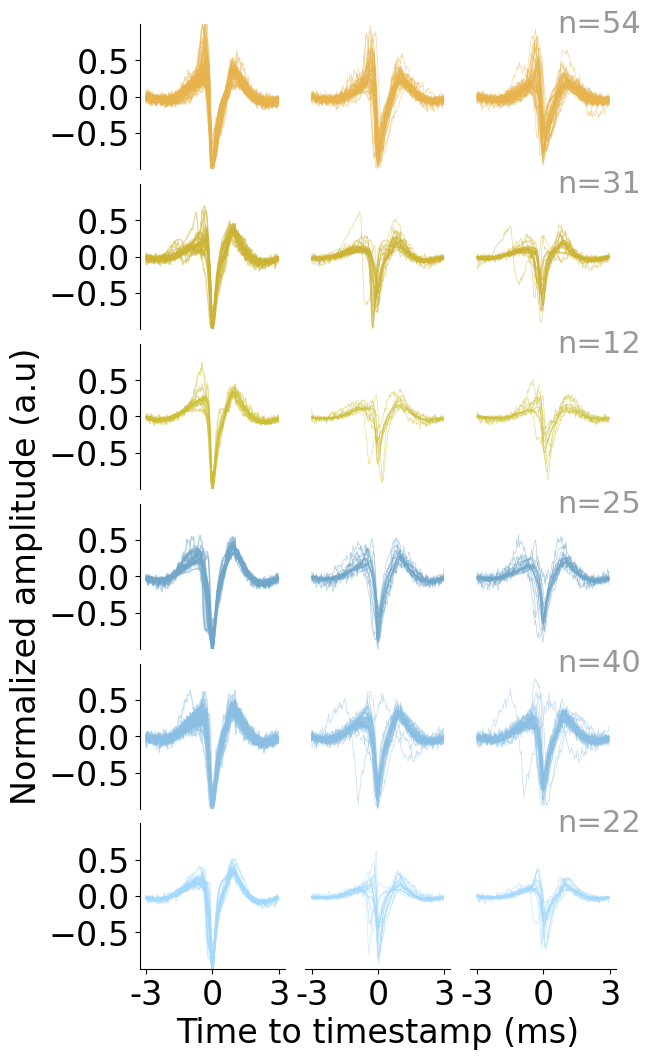

In [73]:
# takes 2 secs
counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [3, 5, 4, 1, 0, 2]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 7 * 1.5))

YLIM = [-1, 1]

for ix, profile_i in enumerate(profiles):

    # site 1
    # unit templates
    axes[ix, 0].plot(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=1,
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].set_yticks([-0.5, 0, 0.5])
    axes[ix, 0].set_ylim(YLIM)

    if ix == 3:
        axes[ix, 0].set_ylabel("Normalized amplitude (a.u)")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    axes[ix, 1].plot(
        normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)

    axes[ix, 1].set_yticks([-0.5, 0, 0.5])
    axes[ix, 1].set_ylim(YLIM)

    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    axes[ix, 2].plot(
        normWFs[
            umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
        ].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 2].set_box_aspect(1)  # square axis

    axes[ix, 2].set_yticks([-0.5, 0, 0.5])
    axes[ix, 2].set_ylim(YLIM)

    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.6, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )

fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.45, hspace=0.1)

# save fig
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/marques_silico_spike_shape.pdf",
    **savefig_cfg,
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/marques_silico_spike_shape.svg",
    **savefig_cfg,
)